In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as linalg
import scipy.spatial.distance as dt
import scipy.stats as stats
from icecream import ic

In [2]:
group_means = np.array([[-6.0, -1.0],
                        [-3.0, +2.0],
                        [+3.0, +2.0],
                        [+6.0, -1.0]])

group_covariances = np.array([[[+0.4, +0.0],
                               [+0.0, +4.0]],
                              [[+2.4, -2.0],
                               [-2.0, +2.4]],
                              [[+2.4, +2.0],
                               [+2.0, +2.4]],
                              [[+0.4, +0.0],
                               [+0.0, +4.0]]])

# read data into memory
data_set = np.genfromtxt("hw05_data_set.csv", delimiter = ",")

# get X values
X = data_set[:, [0, 1]]

# set number of clusters
K = 4

In [3]:
# STEP 2
# should return initial parameter estimates
# as described in the homework description
def initialize_parameters(X, K):
    # your implementation starts below
    initial_means = np.genfromtxt("hw05_initial_centroids.csv", delimiter = ",")
    assert initial_means.shape == (K, X.shape[1])
    means = initial_means[:K]

    # Assign points by distance to initial means
    distances = dt.cdist(X, means)
    assignments = np.argmin(distances, axis=1)
    covariances = np.array([np.cov(X[assignments == k].T) for k in range(K)])
    priors = np.array([np.mean(assignments == k) for k in range(K)])
    # your implementation ends above
    return(means, covariances, priors)

means, covariances, priors = initialize_parameters(X, K)

In [4]:
def calculate_responsibilities(X, means, covariances, priors):
    K = means.shape[0]
    N = X.shape[0]

    responsibilities = np.zeros((N, K))
    for k in range(K):
        rv = stats.multivariate_normal(means[k], covariances[k])
        probabilities = rv.pdf(X)
        responsibilities[:, k] = probabilities * priors[k] # P(x|k) * P(k)
    responsibilities_sum  = np.sum(responsibilities, axis=1)[:, np.newaxis] # sum_k P(x|k) * P(k)
    responsibilities = responsibilities / responsibilities_sum #normalized probabilities

    return probabilities
calculate_responsibilities(X, means, covariances, priors)

array([2.73115518e-04, 5.27280930e-13, 4.21371750e-07, 1.56166973e-03,
       1.35809200e-06, 9.64857708e-13, 1.40285619e-05, 7.76834497e-09,
       1.72958742e-06, 4.08013911e-06, 4.41889306e-09, 6.23872674e-07,
       1.89540047e-04, 9.01579491e-04, 3.55409229e-04, 9.83214185e-05,
       9.87587434e-11, 1.58444580e-07, 2.56015046e-07, 9.05681623e-05,
       2.42435832e-06, 9.60237852e-04, 6.41504525e-06, 7.29762428e-06,
       1.38940443e-05, 2.22534992e-09, 3.88837169e-05, 2.35930371e-03,
       9.84538208e-05, 1.83586693e-09, 3.53705863e-07, 6.68984200e-10,
       1.94267073e-04, 4.55291962e-04, 3.84314289e-06, 1.82709214e-03,
       2.29506294e-04, 9.76086669e-04, 1.97174837e-03, 1.88688861e-09,
       5.15743383e-05, 1.03372758e-08, 2.18725670e-04, 7.20185071e-13,
       2.64090763e-03, 6.10450804e-04, 3.69951105e-07, 2.47979600e-11,
       2.23664365e-03, 7.06127367e-08, 5.87670009e-07, 2.91154546e-05,
       3.61434857e-06, 5.04141436e-05, 6.59532019e-10, 9.06067239e-10,
      

In [21]:
def update_means(X, responsibilities):

    K = responsibilities.shape[1]
    # Initialize an array to hold the new means
    new_means = np.zeros((K, X.shape[1]))
    
    # Update each mean
    for k in range(K):
        # Calculate the weighted sum of all points for the current cluster
        weighted_sum = np.sum(responsibilities[:, k][:, np.newaxis] * X, axis=0)
        
        # Normalize by the sum of the responsibilities for the current cluster
        new_means[k] = weighted_sum / np.sum(responsibilities[:, k])
    return new_means

In [22]:
def update_covariances(X, responsibilities, means):
    K = responsibilities.shape[1]
    n_features = X.shape[1]
    
    new_covariances = np.zeros((K, n_features, n_features))
    
    for k in range(K):
        # Calculate the weighted outer product of the deviations
        deviation = X - means[k]  # Deviation of data points from the mean
        weighted_outer_product = np.zeros((n_features, n_features))
        
        for i in range(X.shape[0]):
            weighted_outer_product += responsibilities[i, k] * np.outer(deviation[i], deviation[i])
        
        # Normalize by the sum of the responsibilities
        new_covariances[k] = weighted_outer_product / np.sum(responsibilities[:, k])
    
    return new_covariances


In [23]:
def update_priors(responsibilities):
    N = responsibilities.shape[0]
    new_priors = np.sum(responsibilities, axis=0) / N
    return new_priors


In [24]:
# STEP 3
# should return final parameter estimates of
# EM clustering algorithm
def em_clustering_algorithm(X, K, means, covariances, priors, iterations=100):
    # your implementation starts below
    assert not (len(means) > K)
    if len(means) < K:
        print("Warning: Number of means is not equal to K. Using means up to K.")
        means = means[:K]

    

    for _ in range(iterations):
        # E-step: Calculate responsibilities
        responsibilities = calculate_responsibilities(X, means, covariances, priors)

        # M-step: Update parameters
        means = update_means(X, responsibilities)
        covariances = update_covariances(X, responsibilities, means)
        priors = update_priors(responsibilities)

    # Compute final assignments based on the highest responsibility
    assignments = np.argmax(responsibilities, axis=1)
    # your implementation ends above
    return(means, covariances, priors, assignments)

means, covariances, priors, assignments = em_clustering_algorithm(X, K, means, covariances, priors)
print(means)
print(priors)

[[-6.04008414 -0.99017705]
 [-2.84646474  1.92541135]
 [ 5.93045701 -1.1106533 ]
 [ 3.14181338  2.14469912]]
[0.25421917 0.26069595 0.24900801 0.23607687]


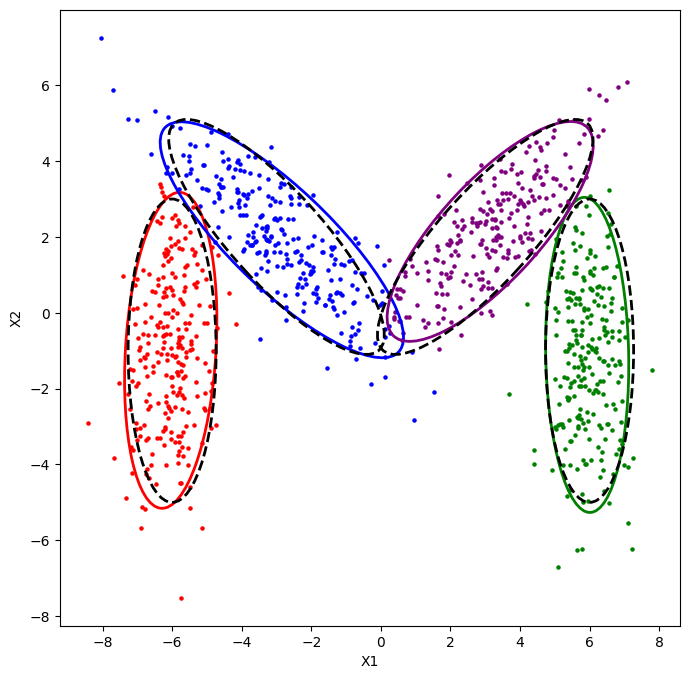

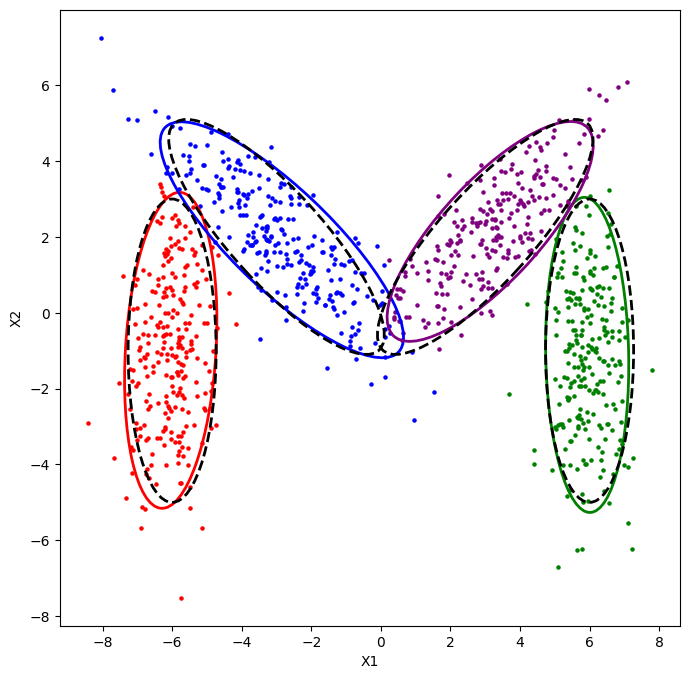

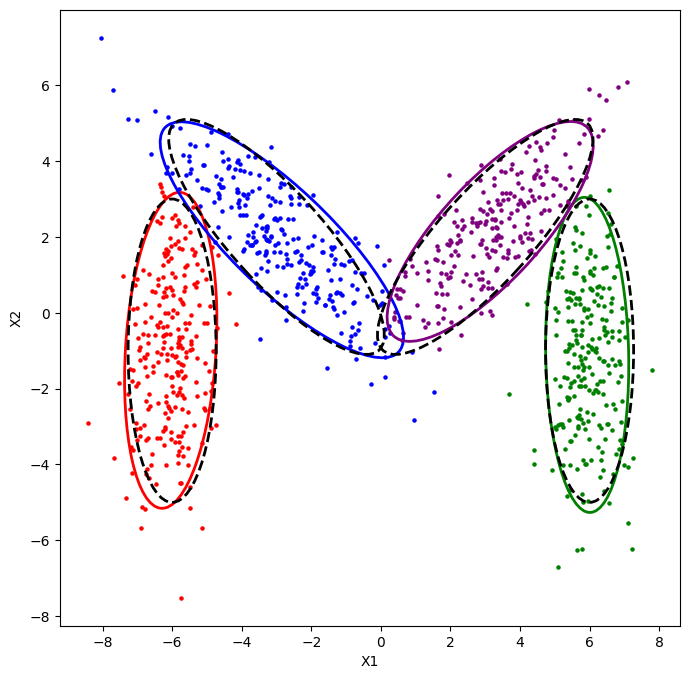

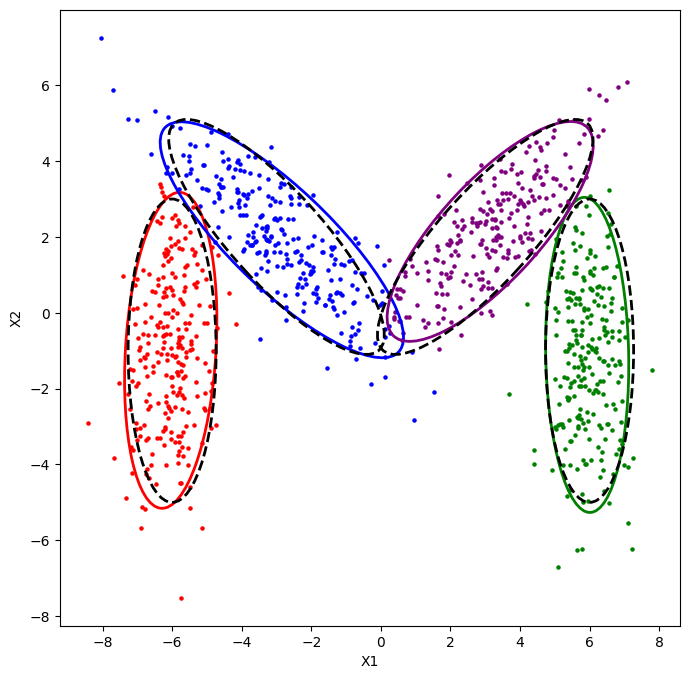

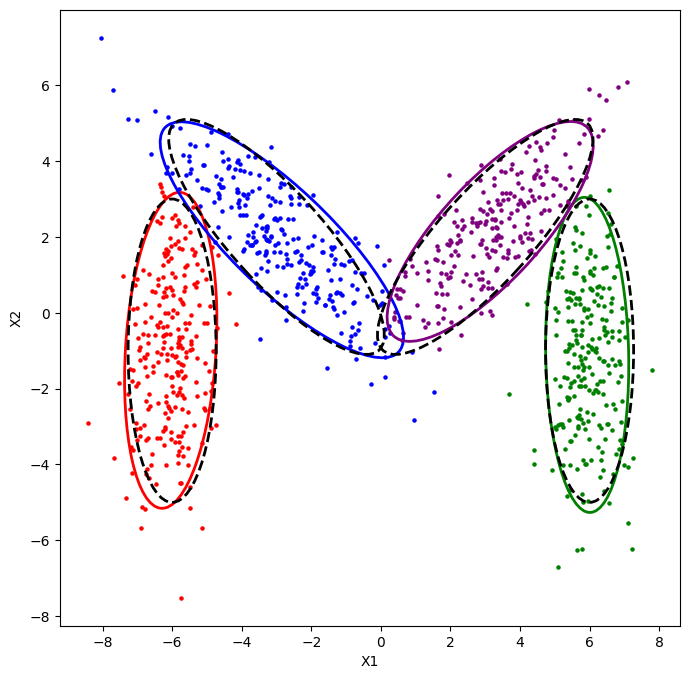

In [26]:
# STEP 4
# should draw EM clustering results as described
# in the homework description
def draw_clustering_results(X, K, group_means, group_covariances, means, covariances, assignments):
    # your implementation starts below
    from matplotlib.patches import Ellipse
    scale_factor = 4
    plt.figure(figsize=(8, 8))
    colors = ['red', 'blue', 'green', 'purple']
    for k in range(K):
        plt.scatter(X[assignments == k, 0], X[assignments == k, 1], c=colors[k], s=5)
    # for mean, color in zip(means, colors):
    #     plt.scatter(mean[0], mean[1], c=color, s=100, edgecolors='k')

    for mean, cov, color in zip(means, covariances, colors):
        eigenvalues, eigenvectors = linalg.eig(cov)
        angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))
        width, height = scale_factor * np.sqrt(eigenvalues) 
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                      edgecolor=color, lw=2, facecolor='none')
        plt.gca().add_artist(ell)

    # Plot the true means and covariances
    for mean, cov in zip(group_means, group_covariances):
        eigenvalues, eigenvectors = linalg.eig(cov)
        angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))
        width, height = scale_factor * np.sqrt(eigenvalues) 
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                      edgecolor="black", lw=2, facecolor='none', linestyle='dashed')
        plt.gca().add_artist(ell)

    plt.xlabel('X1')
    plt.ylabel('X2')    
    
    # your implementation ends above

for iterations in range(95, 100):
    means, covariances, priors = initialize_parameters(X, K)
    means, covariances, priors, assignments = em_clustering_algorithm(X, K, means, covariances, priors, iterations) 
    draw_clustering_results(X, K, group_means, group_covariances, means, covariances, assignments)